In [342]:
import pandas as pd; pd.set_option('precision',4)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np; np.set_printoptions(precision=4,suppress = True)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
import matplotlib.gridspec as gridspec
from datetime import datetime

fontsize = 15 # Set fontsize for all figures
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title


# StandardScale all x-variables - improves performance and robustness of fitted models
from sklearn.preprocessing import StandardScaler

# All subsets need their own scaler in order to call the inverse_transform method
scaler_train = StandardScaler()
scaler_test = StandardScaler()
scaler_all = StandardScaler()


def printf(text, value, pct=False):
    if pct == True:
        print(text, f"{value*100:.4f}%")
    else:
        print(text, f"{value:.4f}")

In [343]:
import os 
cwd = os.getcwd()
print(os.getcwd())
os.chdir('/home/math/PycharmProjects/hmm-master')

/home/math/PycharmProjects/hmm-master


In [344]:
df = pd.read_excel('data/Adjusted Close Price Series Load.xlsx', header = 2, index_col = 'Time / Name')
df_MSCI = df[['MSCI World']]
df_MSCI['Index prices'] = df['MSCI World'] / df.iloc[0, 1] * 100
df_MSCI.head()

,MSCI World,Index prices
Time / Name,,
1980-01-01,7.0217,100.0000
1980-01-02,6.9258,98.6337
1980-01-03,6.9075,98.3727
1980-01-04,6.9630,99.1631
1980-01-07,6.9889,99.5330


In [345]:
df_MSCI['Returns'] = df_MSCI['Index prices'].pct_change()
df_MSCI['Log returns'] = np.log(df_MSCI['Index prices']) - np.log(df_MSCI['Index prices'].shift(1))
#df_MSCI.dropna(inplace=True)
df_MSCI

,MSCI World,Index prices,Returns,Log returns
Time / Name,,,,
1980-01-01,7.0217,100.0000,NaN,NaN
1980-01-02,6.9258,98.6337,-0.0137,-0.0138
1980-01-03,6.9075,98.3727,-0.0026,-0.0027
1980-01-04,6.9630,99.1631,0.0080,0.0080
1980-01-07,6.9889,99.5330,0.0037,0.0037
...,...,...,...,...
2021-01-19,167.7060,2388.3908,0.0033,0.0033
2021-01-20,169.6573,2416.1799,0.0116,0.0116
2021-01-21,169.3605,2411.9531,-0.0017,-0.0018


### Train and Test period

In [346]:
#start_train = '1980-01-01'
#end_train = '2014-01-01'

#start_test = '2014-01-02'
#end_test = '2021-01-25'

# Get train and test as datetimes - used for plotting
start_train_dt = datetime.strptime(start_train, '%Y-%m-%d')
end_train_dt = datetime.strptime(end_train, '%Y-%m-%d')
start_test_dt = datetime.strptime(start_test, '%Y-%m-%d')
end_test_dt = datetime.strptime(end_test, '%Y-%m-%d')

df = df.loc[start_train:end_test]

In [347]:
#Get train & test sets - keep as Dataframe as oppossed to pandas series.
#x_train = pd.DataFrame(df_MSCI.loc[start_train:end_train, 'Log returns'])
#x_test = pd.DataFrame(df_MSCI.loc[start_test:end_test, 'Log returns'])
#x_all = pd.DataFrame(df_MSCI.loc[start_train:end_test, 'Log returns'])

In [348]:
##Scale train & test sets
#x_train_scaled = pd.DataFrame(scaler_train.fit_transform(x_train),
 #            columns = ["Log returns"],
  #           index=x_train.index)
#x_test_scaled = pd.DataFrame(scaler_test.fit_transform(x_test), columns =['Log returns'], index = x_test.index)

#x_all_scaled = pd.DataFrame(scaler_all.fit_transform(x_all), columns = ['Log returns'], index = x_all.index)

In [349]:
#Set variable for index prices and set index 100 to first obs - only used for plotting
prices = df.loc[:,"MSCI World"] / df.iloc[0]["MSCI World"] * 100
df_MSCI['Index prices'] = df.loc[:,"MSCI World"] / df.iloc[0]["MSCI World"] * 100

### Data Exploration

#### Overview of time series


In [350]:
df_MSCI

,MSCI World,Index prices,Returns,Log returns
Time / Name,,,,
1980-01-01,7.0217,100.0000,NaN,NaN
1980-01-02,6.9258,98.6337,-0.0137,-0.0138
1980-01-03,6.9075,98.3727,-0.0026,-0.0027
1980-01-04,6.9630,99.1631,0.0080,0.0080
1980-01-07,6.9889,99.5330,0.0037,0.0037
...,...,...,...,...
2021-01-19,167.7060,2388.3908,0.0033,0.0033
2021-01-20,169.6573,2416.1799,0.0116,0.0116
2021-01-21,169.3605,2411.9531,-0.0017,-0.0018


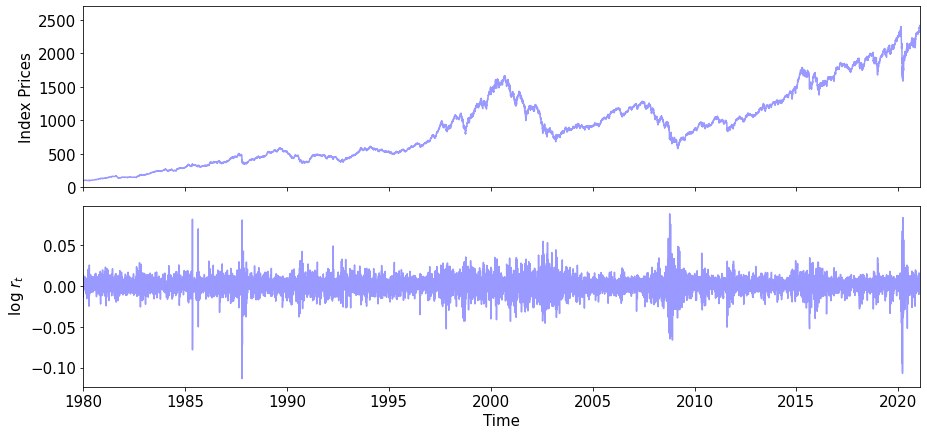

In [351]:
def plot_test_area(ax):
    #Set grey background for in-sample data
    ax.axvspan(start_train_dt, end_train_dt, alpha=0.5, color='white')
    ax.axvspan(start_test_dt, end_test_dt, alpha=0.5, color='grey', label = "Out of sample")

    
#### Plot Index and Log Returns

# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7), sharex=True)
plt.subplots_adjust(wspace = 0.2, hspace=0.1)
labels = ["Index Prices"," log $r_t$"]
variables = [df_MSCI['Index prices'], df_MSCI['Log returns']]
    
for (ax, labels, var) in zip([ax1, ax2], labels, variables):
    ax.plot(df_MSCI.index.values, var, color="b", alpha=0.4)
    ax.set_ylabel(labels)
    ax2.set_xlabel("Time")
    ax.set_xlim(start_train_dt, end_test_dt)
    ax1.set_ylim(0,2700)
    
#ax2.set_ylim(bottom=-0.15)
plt.savefig("Index and return")

    
#fig, ax = plt.subplots(figsize=(15,5))

#plt.plot(prices)
#plt.ylabel('Index Prices')
#plt.xlim(start_train_dt, end_test_dt)
#plt.grid()
#plt.tight_layout()
#plt.savefig("MSCI World")

In [364]:
df_MSCI

,MSCI World,Index prices,Returns,Log returns
Time / Name,,,,
1980-01-01,7.0217,100.0000,NaN,NaN
1980-01-02,6.9258,98.6337,-0.0137,-0.0138
1980-01-03,6.9075,98.3727,-0.0026,-0.0027
1980-01-04,6.9630,99.1631,0.0080,0.0080
1980-01-07,6.9889,99.5330,0.0037,0.0037
...,...,...,...,...
2021-01-19,167.7060,2388.3908,0.0033,0.0033
2021-01-20,169.6573,2416.1799,0.0116,0.0116
2021-01-21,169.3605,2411.9531,-0.0017,-0.0018


In [355]:
# Summary statistics log returns

display(pd.DataFrame(df_MSCI['Log returns'].describe(include='all')).T.round(4))

printf("Skewness = ", stats.skew(data.dropna().round(4))[0])
printf("Excess Kurtosis = ", stats.kurtosis(data.dropna())[0])

,count,mean,std,min,25%,50%,75%,max
Log returns,10714.0,0.0003,0.01,-0.1134,-0.0045,0.0006,0.0055,0.0876


Skewness =  -1.2477
Excess Kurtosis =  18.6880


In [360]:
np.max(df_MSCI['Log returns'].loc[start_train_dt:end_train_dt]) #Test function for the statistics above, out of sample

0.08760270641696177

### ACF and ACF^2 - Absence of Linear Autocorrelation and Volatility clustering


In [379]:
#### Compute ACF for train set:
n_lags = 100
lags = [i for i in range(n_lags)]
acf = sm.tsa.acf(df_MSCI['Log returns'].dropna(),nlags = n_lags)[1:] #The 1: excludes the first observation which obviouslyh is 1.

#### Compute ACF2
acf_abs = sm.tsa.acf(df_nlags=n_lags)[1:]

In [380]:
acf

array([ 0.0305,  0.0065, -0.0024,  0.0003, -0.0003, -0.0515,  0.0272,
       -0.0074,  0.0352,  0.0153,  0.0032,  0.0133, -0.004 ,  0.0233,
       -0.0158,  0.009 ,  0.0116, -0.0306, -0.0033,  0.0034,  0.0061,
       -0.0127,  0.0033, -0.0024,  0.0217, -0.0112, -0.0114,  0.0136,
        0.0251,  0.0045,  0.009 , -0.0091, -0.0041, -0.0168, -0.0204,
       -0.0062,  0.006 , -0.    ,  0.0037,  0.0111, -0.0063,  0.004 ,
        0.0008, -0.0059,  0.0125,  0.0248, -0.0129,  0.0039,  0.0006,
       -0.0021,  0.0068, -0.0134,  0.0235,  0.0133, -0.0038, -0.0063,
       -0.0273,  0.0129,  0.0067, -0.0096, -0.0248, -0.0065,  0.0076,
       -0.0048,  0.0106, -0.0283,  0.0129, -0.0017, -0.0123,  0.0216,
       -0.0095,  0.025 , -0.0068,  0.0107,  0.0012,  0.0057,  0.0188,
       -0.0102,  0.0147, -0.0048,  0.0091, -0.0037, -0.0089,  0.0091,
        0.0122,  0.0182, -0.0103, -0.0014, -0.0046,  0.0039,  0.0007,
       -0.0056, -0.0096, -0.0111, -0.0046, -0.0209,  0.0085,  0.016 ,
        0.0089,  0.0

In [381]:
#### Confidence interval for ACF
acf_conf = [1.96  / np.sqrt(len(x_train)), -1.96 / np.sqrt(len(x_train))]

#### Confidence interval for ACF^2
acf_squared_conf = [1.96 / np.sqrt(len(x_train**2)), - 1.96 / np.sqrt(len(x_train**2))]

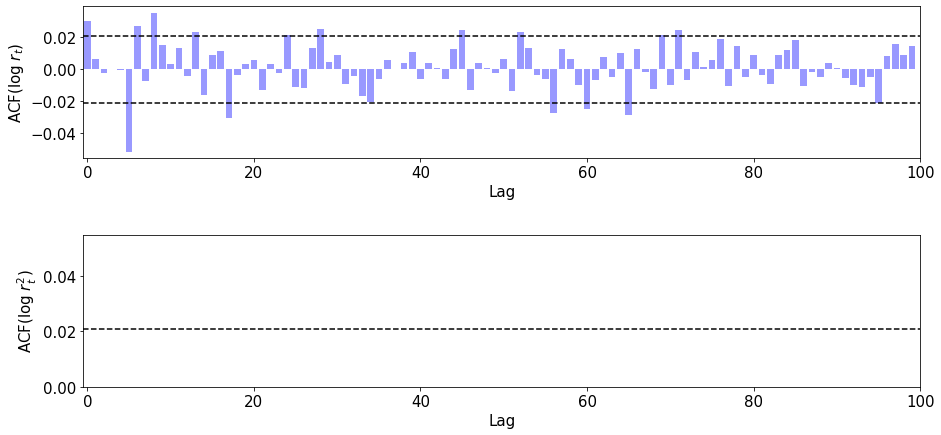

In [382]:
# Create a 2x1 grid to plot in:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(wspace = 0.2, hspace=0.5)

#Plot ACF & PACF
labels = ["ACF(log $r_t)$","ACF(log $r^2_t$)"]
variables = [acf, acf_squared]
confidence = [acf_conf, acf_squared_conf]

for (ax, labels, var, conf) in zip([ax1, ax2], labels, variables, confidence):
    ax.bar(lags, var, color="b", alpha=0.4)
    ax.axhline(conf[0], linestyle = 'dashed', color = 'black')
    ax.axhline(conf[1], linestyle = 'dashed', color = 'black')
    ax.set_ylabel(labels)
    ax.set_xlabel("Lag")
    ax.set_xlim(left=-0.5, right = max(lags)+1)
    
ax2.set_ylim(bottom=0)
plt.savefig("ACF")
